Following the code of Michedev: https://github.com/Michedev/flow-matching-mnist/blob/main/flow-matching-with-mnist-dataset.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Installing and loading the libraries

In [ ]:
# library to handle flow matching
!pip install flow-matching
!pip install datasets
!pip install pytorch_lightning

In [ ]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from torch import nn
import torchvision

# Loading the dataset
MNIST: dataset of images of digits in grayscale

Here, we only want to get the data of digit 8 for the model

In [ ]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
x = dataset.data
x = x.unsqueeze(1)                            # shape: (N, 1, 28, 28)
y = dataset.targets
X = x[y == 8]

In [ ]:
import torch
print("Total number of image digit 8:", len(X))
# Shuffling and splitting
indices = torch.randperm(len(X))
X_shuffled = X[indices]

# 80/20 split
split = int(0.8 * len(X))
X_train = X_shuffled[:split]
X_test = X_shuffled[split:]

print("Train set shape:", X_train.shape)  # [N_train, 1, 28, 28]
print("Test set shape:", X_test.shape)

Total number of image digit 8: 5851
Train set shape: torch.Size([4680, 1, 28, 28])
Test set shape: torch.Size([1171, 1, 28, 28])


# Creating the Unet model

In [ ]:
from flow_matching.path import CondOTProbPath
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.embedding_l = nn.Linear(3, dim)

    def forward(self, time):
        device = time.device
        time = torch.cat([time, torch.cos(time), torch.sin(time)], dim=-1)
        return self.embedding_l(time)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, c=64):
        super().__init__()

        # Time embeddings for each skip connection
        self.time_mlp1 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, c),
            nn.SiLU(),
            nn.Linear(c, c)
        )

        self.time_mlp2 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 2*c),
            nn.SiLU(),
            nn.Linear(2*c, 2*c)
        )

        self.time_mlp3 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 4*c),
            nn.SiLU(),
            nn.Linear(4*c, 4*c)
        )

        # Encoder
        self.conv1 = DoubleConv(in_channels, c)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(c, 2*c)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(2*c, 4*c)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(4*c, 8*c)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(8*c, 4*c, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(12*c, 4*c)  # 4c + 4c + 4c (skip + up + time)
        self.upconv2 = nn.ConvTranspose2d(4*c, 2*c, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(6*c, 2*c)   # 2c + 2c + 2c
        self.upconv1 = nn.ConvTranspose2d(2*c, c, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(3*c, c)     # c + c + c

        self.final_conv = nn.Conv2d(c, out_channels, kernel_size=1)


    def forward(self, x, t):
        # Time embeddings
        t = t.view(-1, 1)
        if t.numel() == 1:
            t = t.expand(x.shape[0], -1)
        t1 = self.time_mlp1(t)        # Shape: [batch, c]
        t2 = self.time_mlp2(t)        # Shape: [batch, 2c]
        t3 = self.time_mlp3(t)        # Shape: [batch, 4c]

        # Encoder
        conv1 = self.conv1(x)                 # Shape: [batch, c, H, W]
        pool1 = self.pool1(conv1)             # Shape: [batch, c, H/2, W/2]

        conv2 = self.conv2(pool1)             # Shape: [batch, 2c, H/2, W/2]
        pool2 = self.pool2(conv2)             # Shape: [batch, 2c, H/4, W/4]

        conv3 = self.conv3(pool2)             # Shape: [batch, 4c, H/4, W/4]
        pool3 = self.pool3(conv3)             # Shape: [batch, 4c, H/8, W/8]

        conv4 = self.conv4(pool3)             # Shape: [batch, 8c, H/8, W/8]

        # Helper function for padding
        def pad_if_needed(upsampled, skip):
            if (upsampled.shape[-1] + 1) == skip.shape[-1]:
                return F.pad(upsampled, (0, 1, 0, 1), mode='replicate')
            return upsampled
        # Decoder Step 1
        up3 = self.upconv3(conv4)              # Shape: [batch, 4c, H/4, W/4]
        up3 = pad_if_needed(up3, conv3)        # Ensure up3 matches conv3 dimensions
        # Reshape t3 to [batch, 4c, H/4, W/4]
        t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up3.size(2), up3.size(3))
        # Alternatively, use expand to save memory:
        # t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, up3.size(2), up3.size(3))
        concat3 = torch.cat([up3, conv3, t_emb3], dim=1)   # Shape: [batch, 12c, H/4, W/4]
        conv5 = self.conv5(concat3)            # Shape: [batch, 4c, H/4, W/4]

        # Decoder Step 2
        up2 = self.upconv2(conv5)              # Shape: [batch, 2c, H/2, W/2]
        up2 = pad_if_needed(up2, conv2)        # Ensure up2 matches conv2 dimensions
        # Reshape t2 to [batch, 2c, H/2, W/2]
        t_emb2 = t2.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up2.size(2), up2.size(3))
        concat2 = torch.cat([up2, conv2, t_emb2], dim=1)   # Shape: [batch, 6c, H/2, W/2]
        conv6 = self.conv6(concat2)            # Shape: [batch, 2c, H/2, W/2]

        # Decoder Step 3
        up1 = self.upconv1(conv6)              # Shape: [batch, c, H, W]
        up1 = pad_if_needed(up1, conv1)        # Ensure up1 matches conv1 dimensions
        # Reshape t1 to [batch, c, H, W]
        t_emb1 = t1.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up1.size(2), up1.size(3))
        concat1 = torch.cat([up1, conv1, t_emb1], dim=1)   # Shape: [batch, 3c, H, W]
        conv7 = self.conv7(concat1)            # Shape: [batch, c, H, W]

        # Final Convolution
        return self.final_conv(conv7)          # Shape: [batch, out_channels, H, W]

# Creating our Flow Matching model

In [ ]:
import argparse
from typing import Optional, Tuple

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import pytorch_lightning as pl

# Importing flow_matching library components
# Adjusting the import paths based on the actual library structure
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class ImageFlowMatcher(pl.LightningModule):
    """
    Flow Matching model for MNIST image generation.
    Utilizes the flow_matching library for path sampling and loss computation.
    """

    def __init__(
        self,
        lr: float = 1e-4,
        num_train_timesteps: int = 1000,
        sigma: float = 0.1,
        step_size: float = 0.05,
        num_steps: int = 1000,
        use_cuda: bool = True
    ):
        super(ImageFlowMatcher, self).__init__()
        self.save_hyperparameters()  # Saving hyperparameters for easy access later

        self.lr = lr
        self.num_train_timesteps = num_train_timesteps
        self.sigma = sigma
        self.step_size = step_size
        self.num_steps = num_steps
        self.normalize_data = True  # Assuming normalization in training_step

        # Initializing the CNN model as the velocity field
        self.model = UNet(1, 1, c=32)

        # Initializing the probability path for flow matching
        self.prob_path = CondOTProbPath()

        self.criterion = nn.MSELoss()

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the CNN model.

        Args:
            xt (torch.Tensor): Current state tensor.
            t (torch.Tensor): Time scalar.

        Returns:
            torch.Tensor: Velocity field tensor.
        """
        return self.model(x, t)

    def generate(
        self,
        batch_size: int = 32,
        sample_image_size: Tuple[int, int, int] = (1, 28, 28),
        step_size: float = 0.05,
        num_steps: Optional[int] = None
    ) -> torch.Tensor:
        """
        Generate images using the trained flow model via ODE integration.

        Args:
            batch_size (int): Number of images to generate.
            sample_image_size (Tuple[int, int, int]): Size of each sample image (C, H, W).
            step_size (float): Integration step size.
            num_steps (Optional[int]): Number of integration steps. Defaults to 2.

        Returns:
            torch.Tensor: Generated images tensor.
        """
        if num_steps is None:
            num_steps = 2
        solver = ODESolver(velocity_model=self.model)
        # Initializing from Gaussian noise
        x_init = torch.randn(batch_size, *sample_image_size, device=self.device)

        # Defining a uniform time grid
        time_grid = torch.linspace(0, 1, steps=num_steps, device=self.device)

        # Performing ODE integration using the solver
        generated = solver.sample(time_grid=time_grid, x_init=x_init, method='dopri5', step_size=step_size, atol=1e-4, rtol=1e-4)

        # Denormalizing if needed
        if self.normalize_data:
            generated = (generated + 1) / 2  # transposes from [-1, 1] to [0, 1]
            generated = torch.clamp(generated, 0.0, 1.0)

        return generated

    def training_step(self, batch, batch_idx):
        """
        Training step for flow matching.

        Args:
            batch (tuple): A batch of data containing images and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Training loss.
        """
        images = batch[0]  # MNIST returns (images, labels)

        # Normalizing images to [-1, 1]
        if self.normalize_data:
            images = images.float() / 255.
            images = images * 2 - 1  # Normalizing [0,1] to [-1,1]

        # Sampling initial noise x0
        x0 = torch.randn_like(images)

        # Sampling a random t in [0,1] for each sample in the batch
        t = torch.rand(images.size(0), device=self.device)

        # Sampling paths for flow matching
        path_batch = self.prob_path.sample(x0, images, t)

        # Predicting velocity field at x_t

        # Predicting velocity field at x_t
        vt = self.forward(path_batch.x_t, path_batch.t)  # Unconditional generation

        # Computing flow matching loss: MSE between predicted velocity and true velocity
        loss = self.criterion(vt, path_batch.dx_t)

        # Logging the training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for flow matching.

        Args:
            batch (tuple): A batch of data containing images and labels.
            batch_idx (int): Index of the batch.
        """
        images  = batch[0]

        # Normalizing images to [-1, 1]
        if self.normalize_data:
            images = images.float() / 255.
            images = images * 2 - 1 # Normalizing [0,1] to [-1,1]

        # Sampling the initial noise x0
        x0 = torch.randn_like(images)

        # Sampling a random t in [0,1] for each sample in the batch
        t = torch.rand(images.size(0), device=self.device)

        # Sampling the paths for flow matching
        path_batch = self.prob_path.sample(x0, images, t)

        # Predicting the velocity field at x_t
        vt = self.forward(path_batch.x_t, path_batch.t)

        # Computing the flow matching loss
        loss = self.criterion(vt, path_batch.dx_t)

        # Logging the validation loss
        self.log('val_loss', loss, prog_bar=True, logger=True)

        # Generating and logging the sample images
        if batch_idx == 0:
            sample_images = self.generate(batch_size=16)
            grid = torchvision.utils.make_grid(sample_images, nrow=4, normalize=False, value_range=(0,1))
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()
            plt.close()

    def test_step(self, batch, batch_idx):
        """
        Validation step for flow matching.

        Args:
            batch (tuple): A batch of data containing images and labels.
            batch_idx (int): Index of the batch.
        """
        images  = batch[0]

        # Normalizing images to [-1, 1]
        if self.normalize_data:
            images = images.float() / 255.
            images = images * 2 - 1 # Normalizing [0,1] to [-1,1]

        # Sampling the initial noise x0
        x0 = torch.randn_like(images)

        # Sampling a random t in [0,1] for each sample in the batch
        t = torch.rand(images.size(0), device=self.device)

        # Sampling the paths for flow matching
        path_batch = self.prob_path.sample(x0, images, t)

        # Predicting the velocity field at x_t
        vt = self.forward(path_batch.x_t, path_batch.t)

        # Computing the flow matching loss
        loss = self.criterion(vt, path_batch.dx_t)

        # Logging the validation loss
        self.log('val_loss', loss, prog_bar=True, logger=True)

        # Generating and logging the sample images
        if batch_idx == 0:
            sample_images = self.generate(batch_size=16)
            return sample_images

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
            torch.optim.Optimizer: Configured optimizer.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer

    @staticmethod
    def add_model_specific_args(parser):
        """
        Add model-specific command-line arguments.

        Args:
            parser (argparse.ArgumentParser): Argument parser.

        Returns:
            argparse.ArgumentParser: Updated parser with model-specific arguments.
        """
        group_parser = parser.add_argument_group(title='FlowMatcher')
        group_parser.add_argument('--lr', type=float, default=1e-4, help='Learning rate')
        group_parser.add_argument('--num_train_timesteps', type=int, default=1000, help='Number of ODE time steps')
        group_parser.add_argument('--sigma', type=float, default=0.1, help='Sigma for the Flow Matcher')
        group_parser.add_argument('--step_size', type=float, default=0.05, help='ODE integration step size')
        group_parser.add_argument('--num_steps', type=int, default=1000, help='Number of ODE integration steps')
        return parser

In [ ]:
model = ImageFlowMatcher()

# Training step

In [ ]:
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=100, accelerator='gpu', devices=-1, strategy='ddp_notebook')
else:
    trainer = pl.Trainer(max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train)
train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test)
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 2.1 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.592     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.11/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


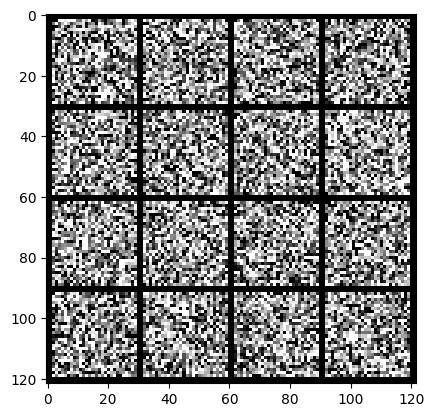

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

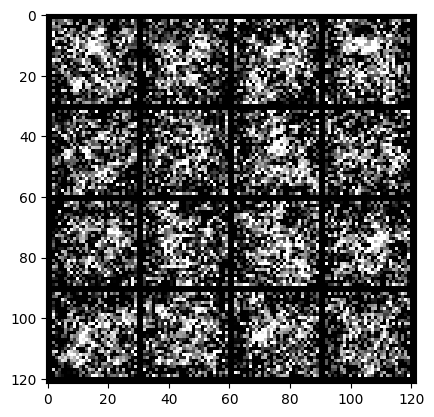

Validation: |          | 0/? [00:00<?, ?it/s]

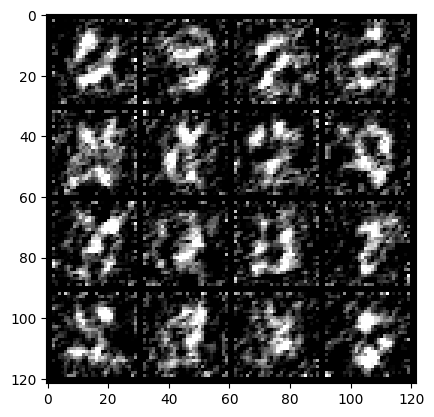

Validation: |          | 0/? [00:00<?, ?it/s]

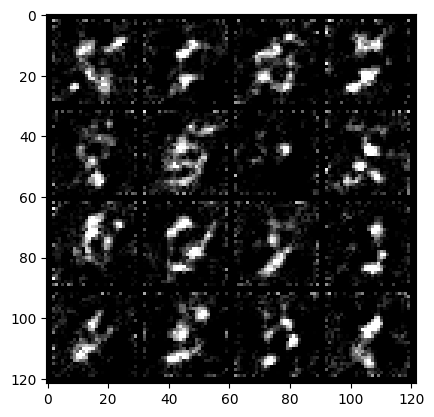

Validation: |          | 0/? [00:00<?, ?it/s]

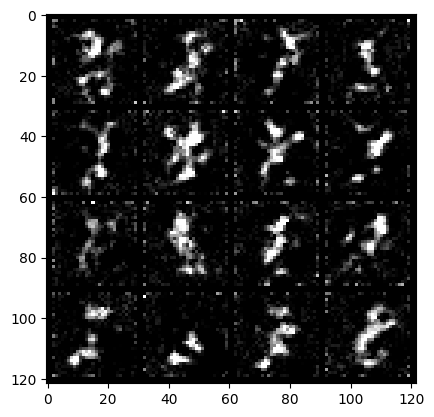

Validation: |          | 0/? [00:00<?, ?it/s]

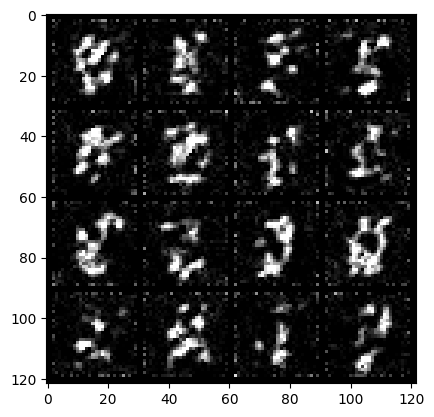

Validation: |          | 0/? [00:00<?, ?it/s]

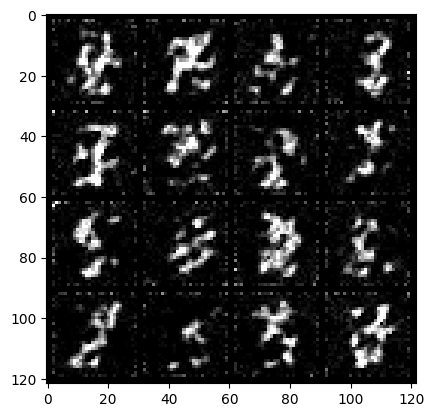

Validation: |          | 0/? [00:00<?, ?it/s]

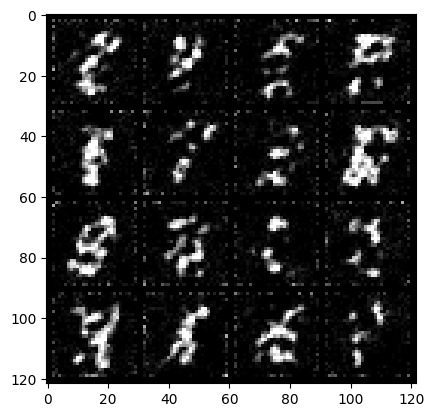

Validation: |          | 0/? [00:00<?, ?it/s]

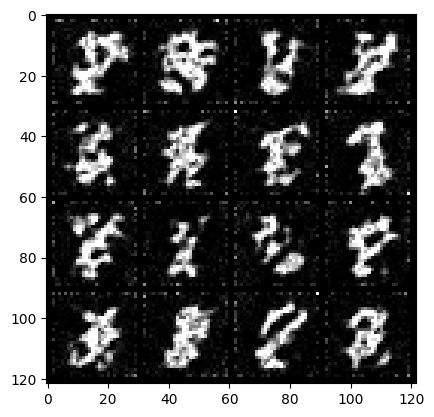

Validation: |          | 0/? [00:00<?, ?it/s]

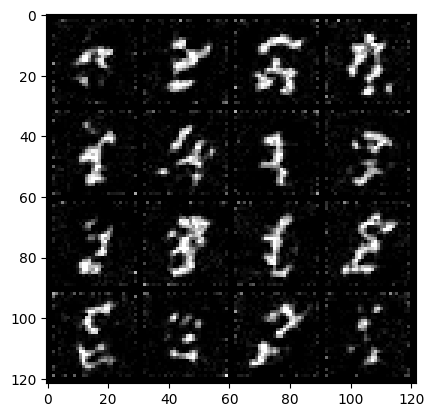

Validation: |          | 0/? [00:00<?, ?it/s]

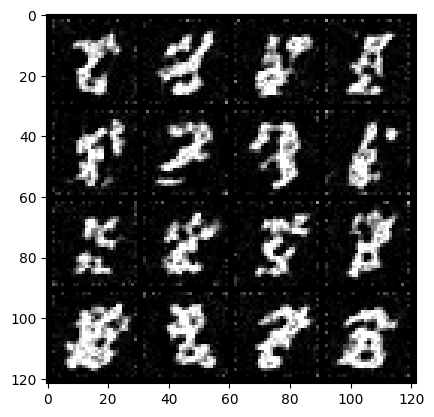

Validation: |          | 0/? [00:00<?, ?it/s]

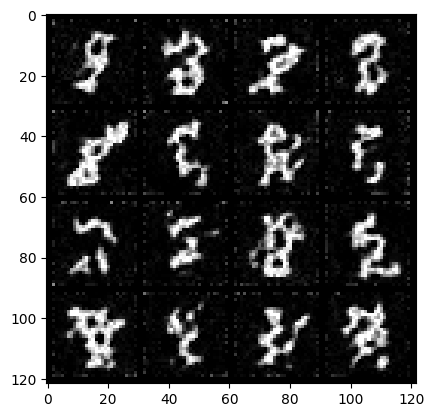

Validation: |          | 0/? [00:00<?, ?it/s]

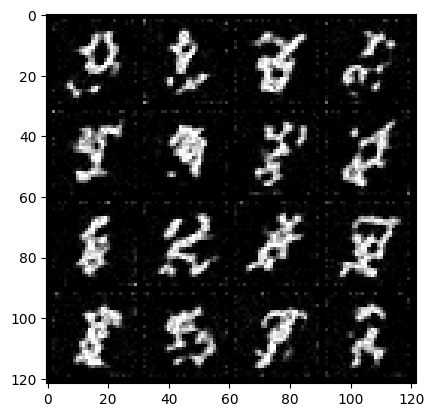

Validation: |          | 0/? [00:00<?, ?it/s]

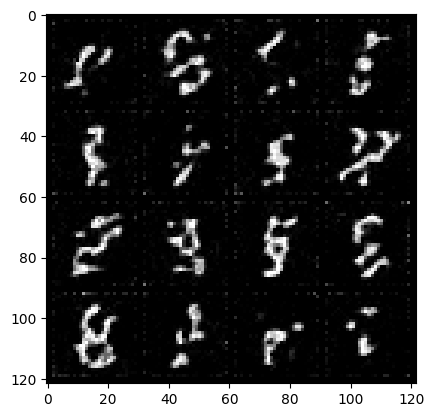

Validation: |          | 0/? [00:00<?, ?it/s]

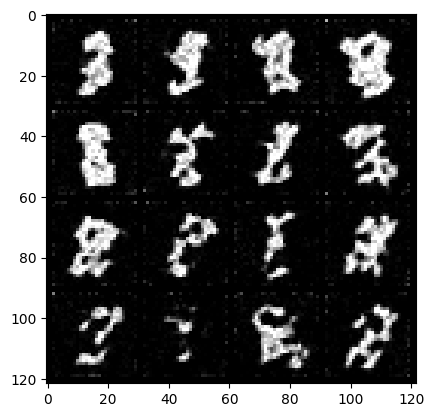

Validation: |          | 0/? [00:00<?, ?it/s]

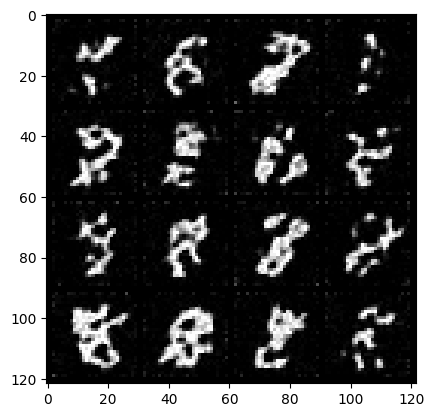

Validation: |          | 0/? [00:00<?, ?it/s]

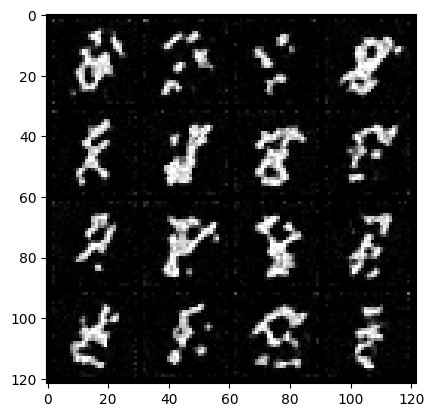

Validation: |          | 0/? [00:00<?, ?it/s]

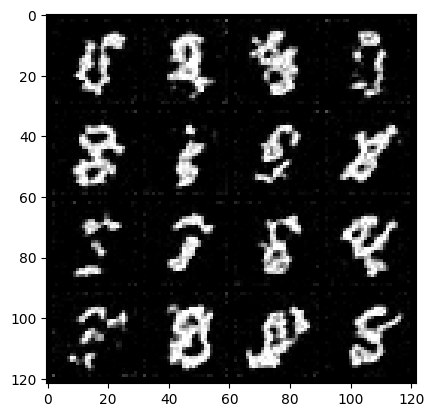

Validation: |          | 0/? [00:00<?, ?it/s]

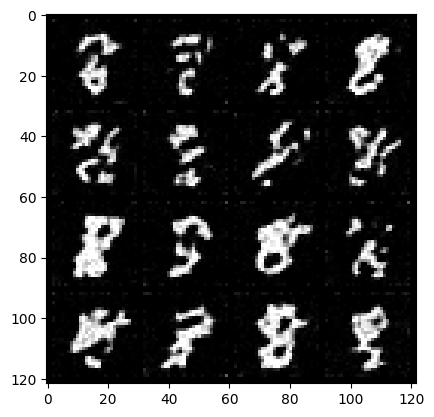

Validation: |          | 0/? [00:00<?, ?it/s]

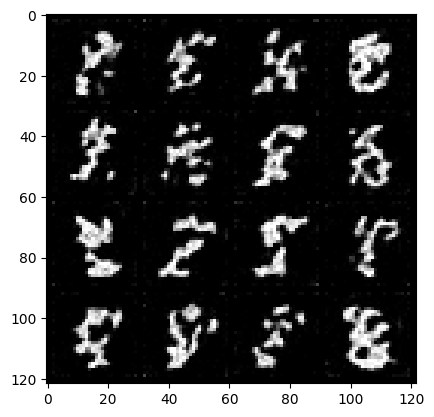

Validation: |          | 0/? [00:00<?, ?it/s]

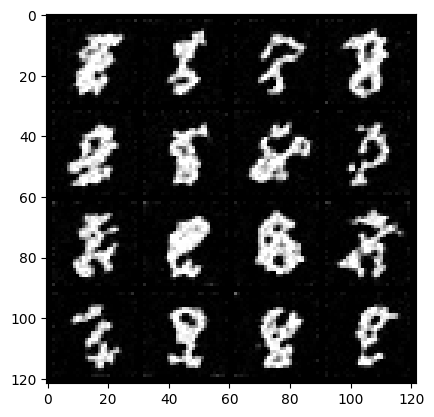

Validation: |          | 0/? [00:00<?, ?it/s]

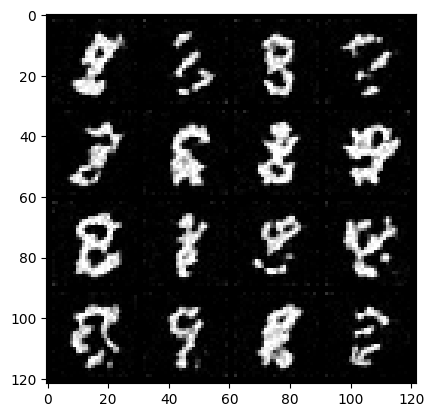

Validation: |          | 0/? [00:00<?, ?it/s]

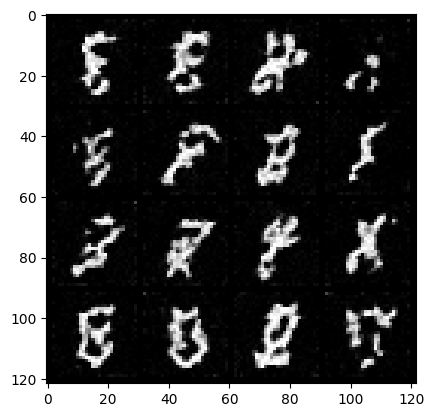

Validation: |          | 0/? [00:00<?, ?it/s]

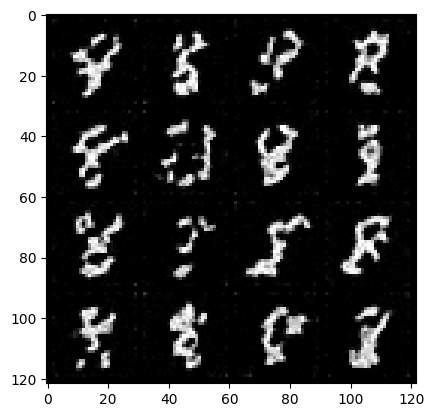

Validation: |          | 0/? [00:00<?, ?it/s]

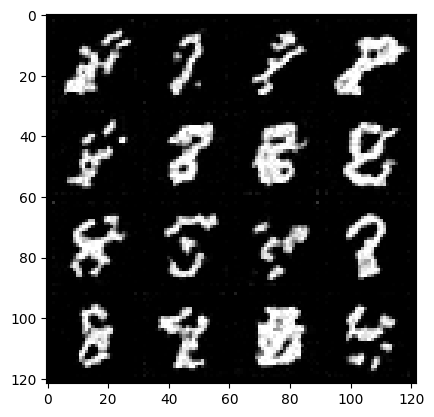

Validation: |          | 0/? [00:00<?, ?it/s]

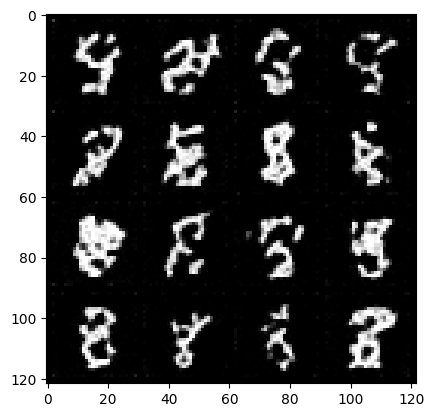

Validation: |          | 0/? [00:00<?, ?it/s]

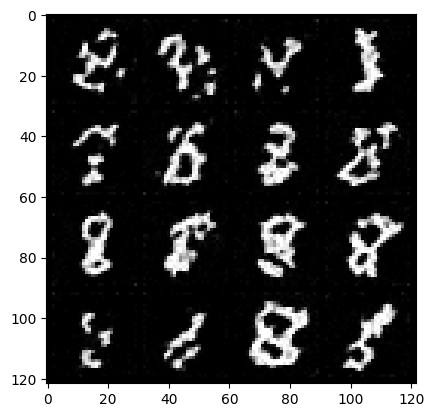

Validation: |          | 0/? [00:00<?, ?it/s]

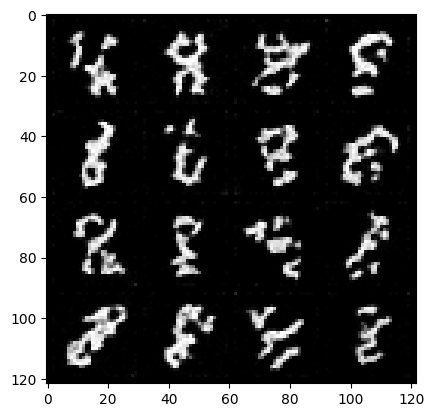

Validation: |          | 0/? [00:00<?, ?it/s]

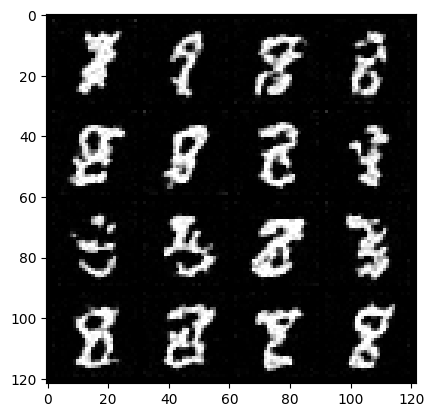

Validation: |          | 0/? [00:00<?, ?it/s]

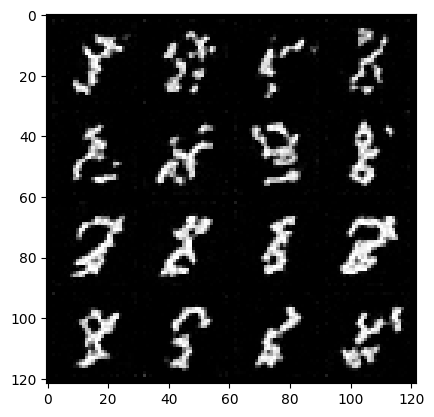

Validation: |          | 0/? [00:00<?, ?it/s]

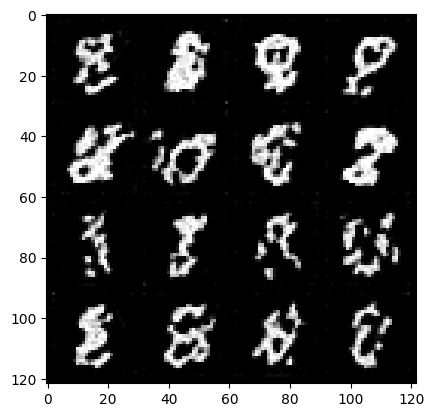

Validation: |          | 0/? [00:00<?, ?it/s]

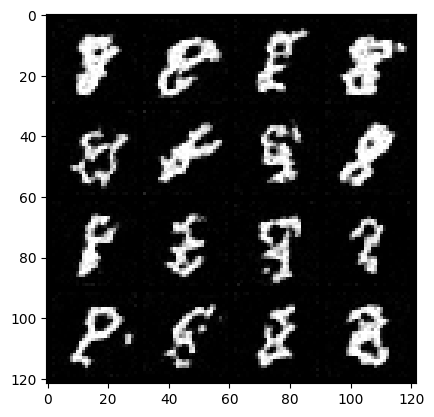

Validation: |          | 0/? [00:00<?, ?it/s]

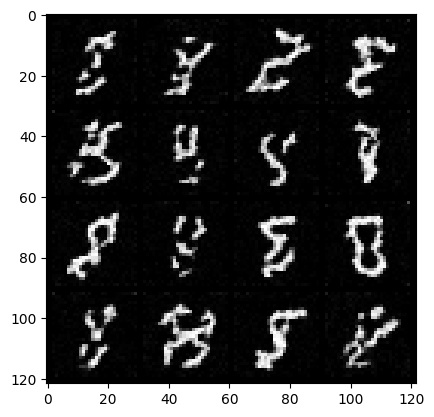

Validation: |          | 0/? [00:00<?, ?it/s]

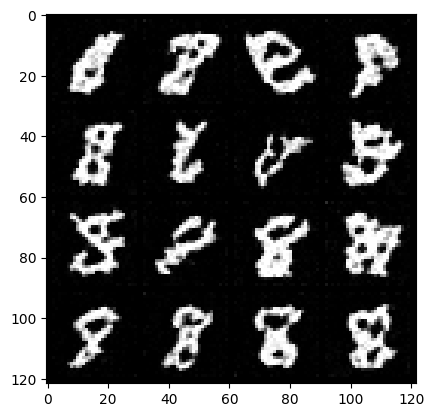

Validation: |          | 0/? [00:00<?, ?it/s]

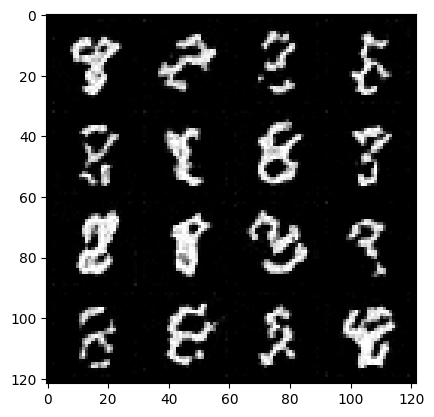

Validation: |          | 0/? [00:00<?, ?it/s]

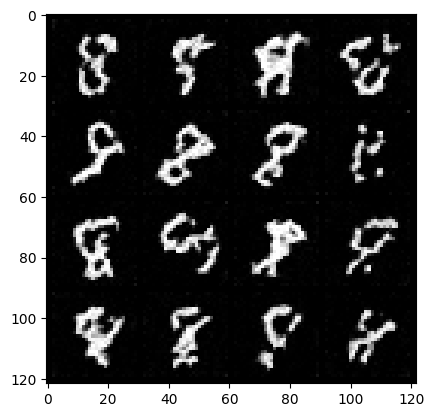

Validation: |          | 0/? [00:00<?, ?it/s]

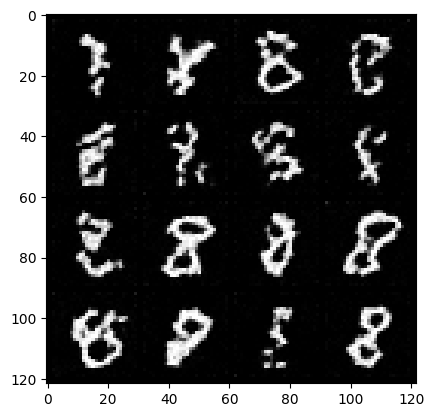

Validation: |          | 0/? [00:00<?, ?it/s]

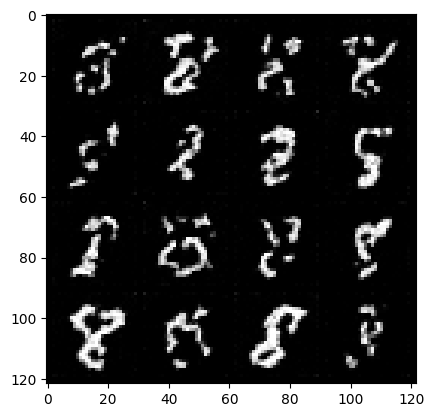

Validation: |          | 0/? [00:00<?, ?it/s]

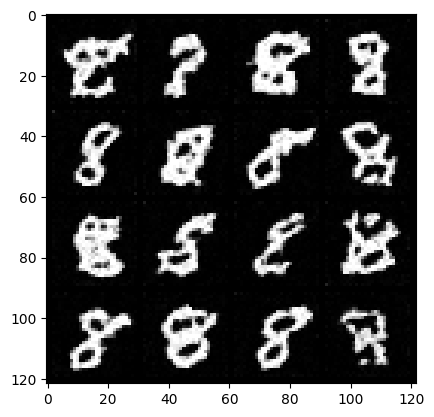

Validation: |          | 0/? [00:00<?, ?it/s]

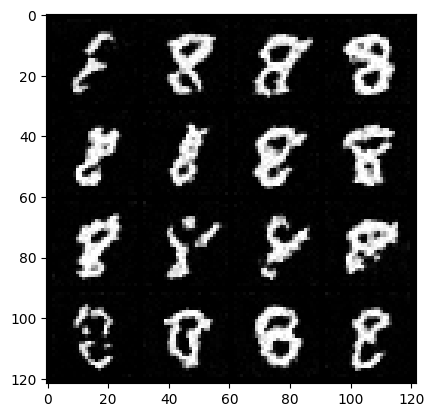

Validation: |          | 0/? [00:00<?, ?it/s]

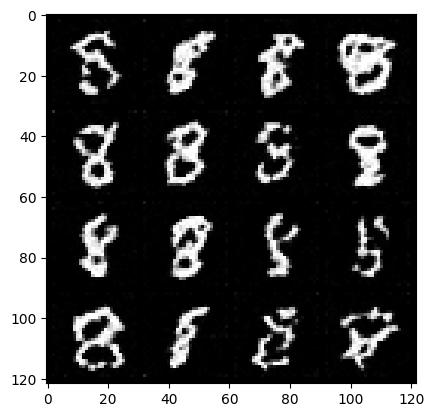

Validation: |          | 0/? [00:00<?, ?it/s]

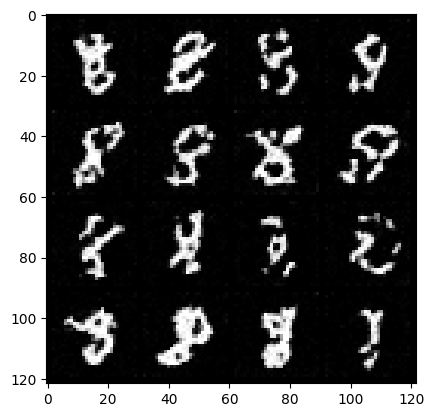

Validation: |          | 0/? [00:00<?, ?it/s]

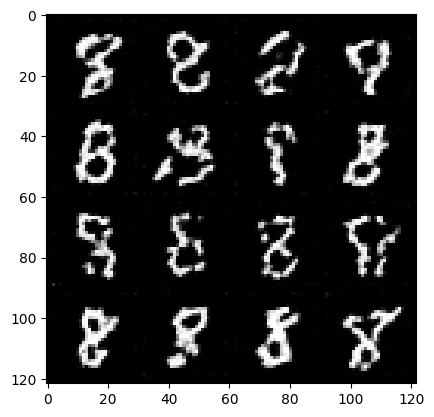

Validation: |          | 0/? [00:00<?, ?it/s]

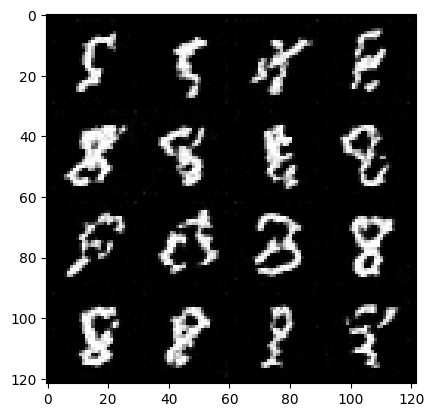

Validation: |          | 0/? [00:00<?, ?it/s]

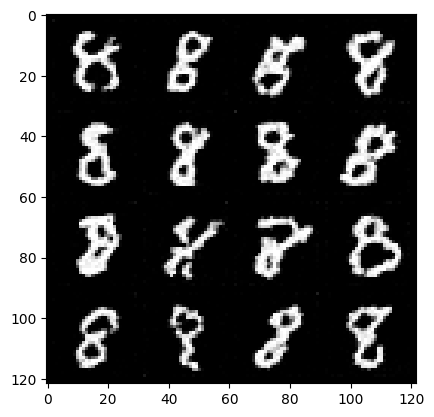

Validation: |          | 0/? [00:00<?, ?it/s]

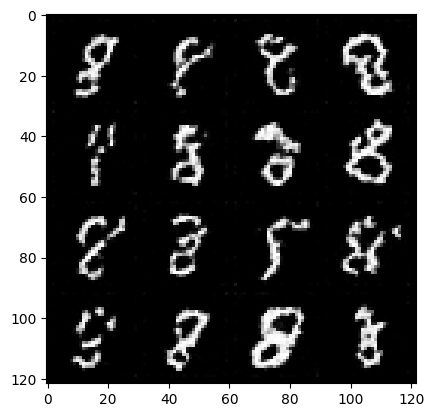

Validation: |          | 0/? [00:00<?, ?it/s]

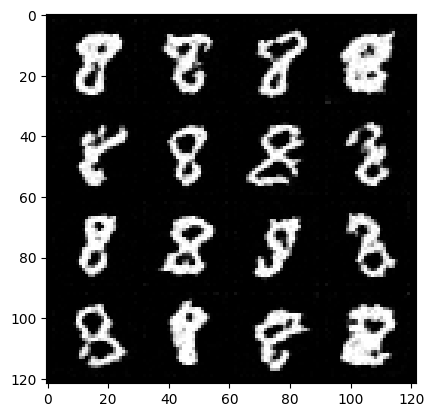

Validation: |          | 0/? [00:00<?, ?it/s]

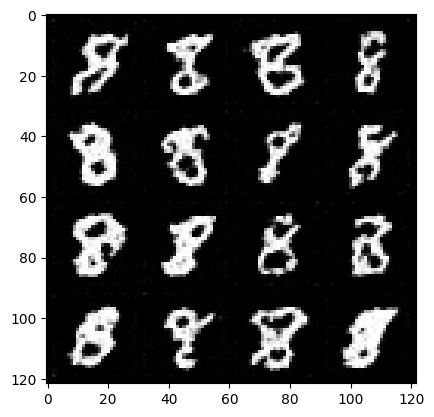

Validation: |          | 0/? [00:00<?, ?it/s]

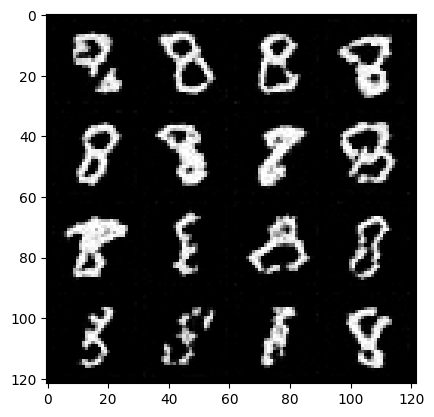

Validation: |          | 0/? [00:00<?, ?it/s]

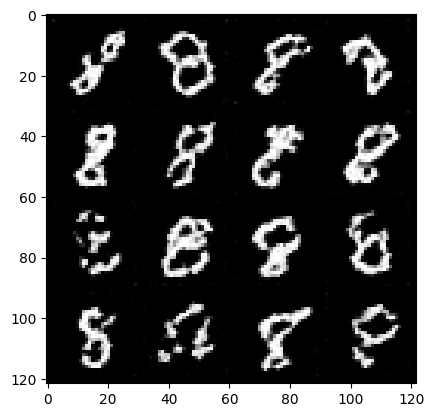

Validation: |          | 0/? [00:00<?, ?it/s]

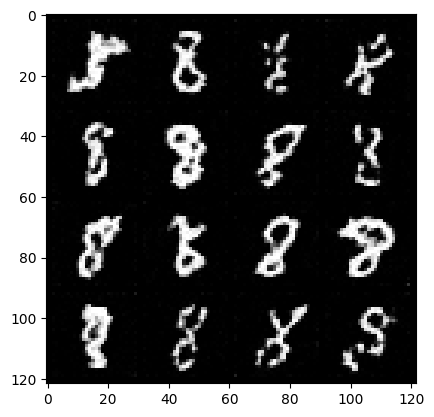

Validation: |          | 0/? [00:00<?, ?it/s]

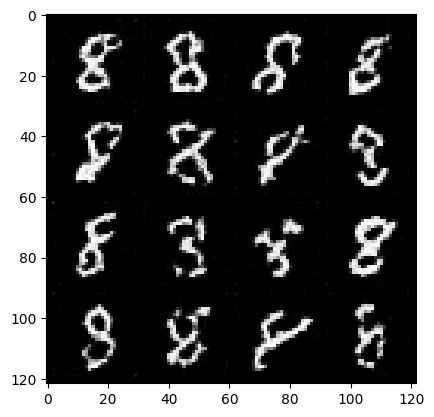

Validation: |          | 0/? [00:00<?, ?it/s]

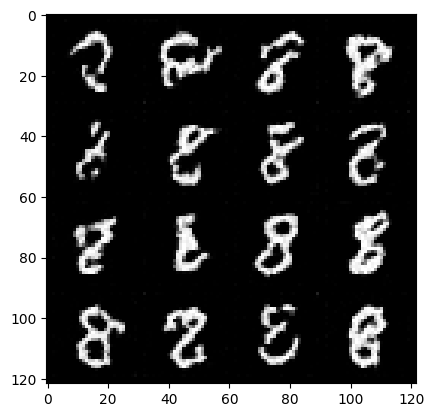

Validation: |          | 0/? [00:00<?, ?it/s]

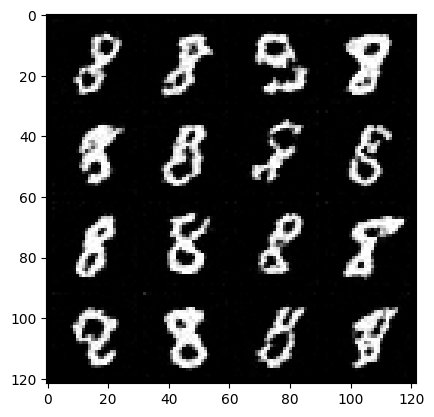

Validation: |          | 0/? [00:00<?, ?it/s]

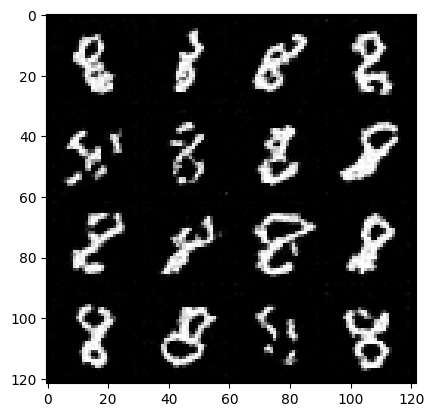

Validation: |          | 0/? [00:00<?, ?it/s]

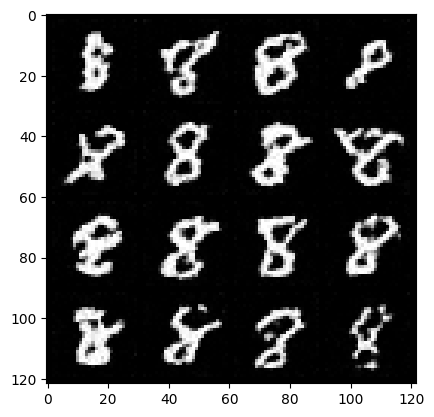

Validation: |          | 0/? [00:00<?, ?it/s]

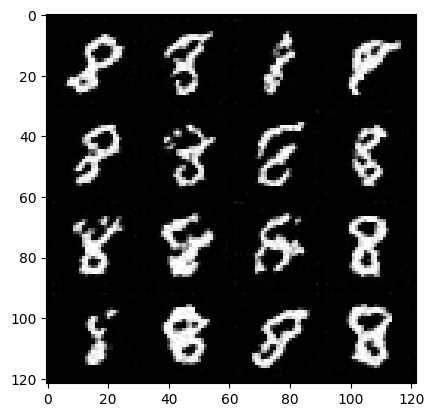

Validation: |          | 0/? [00:00<?, ?it/s]

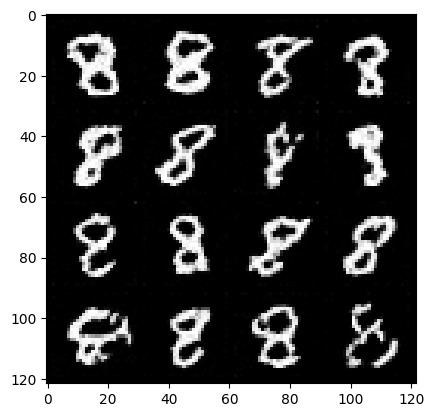

Validation: |          | 0/? [00:00<?, ?it/s]

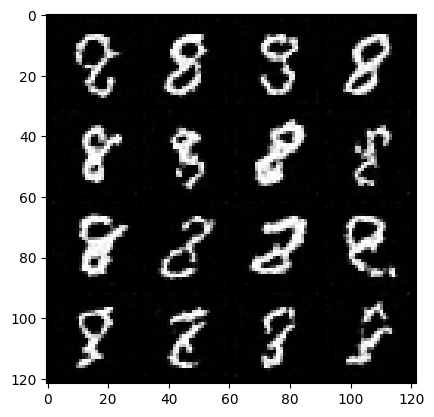

Validation: |          | 0/? [00:00<?, ?it/s]

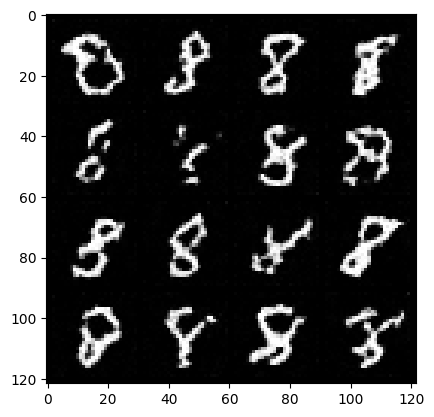

Validation: |          | 0/? [00:00<?, ?it/s]

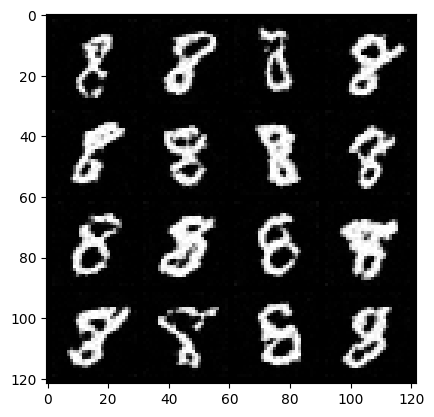

Validation: |          | 0/? [00:00<?, ?it/s]

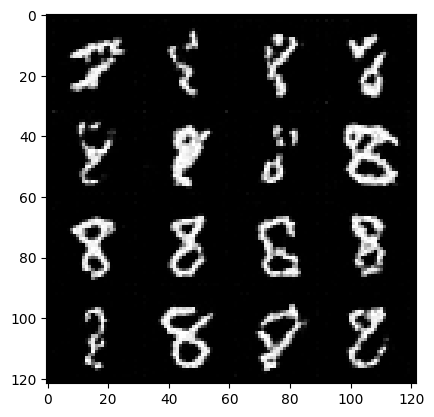

Validation: |          | 0/? [00:00<?, ?it/s]

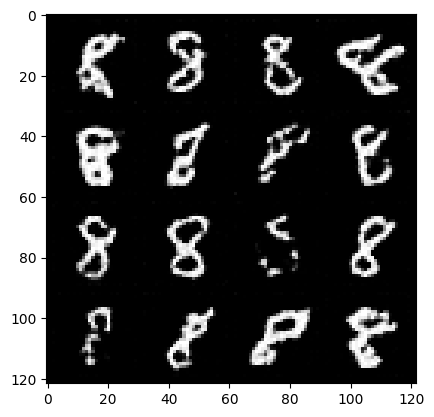

Validation: |          | 0/? [00:00<?, ?it/s]

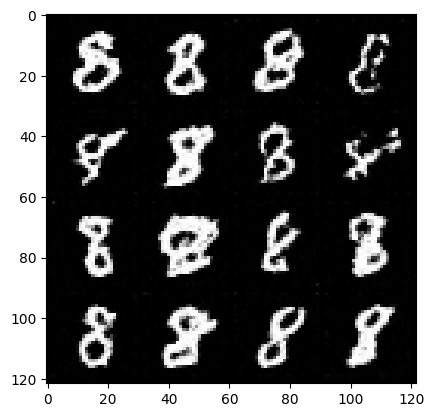

Validation: |          | 0/? [00:00<?, ?it/s]

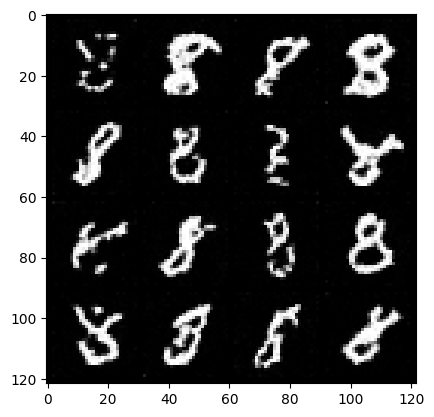

Validation: |          | 0/? [00:00<?, ?it/s]

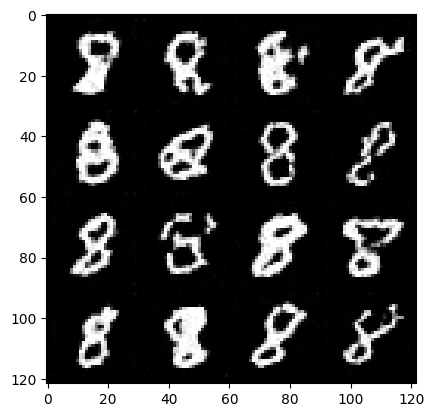

Validation: |          | 0/? [00:00<?, ?it/s]

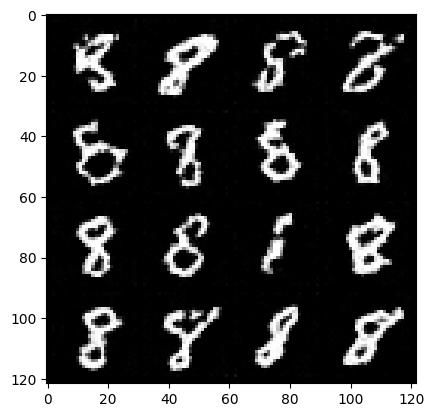

Validation: |          | 0/? [00:00<?, ?it/s]

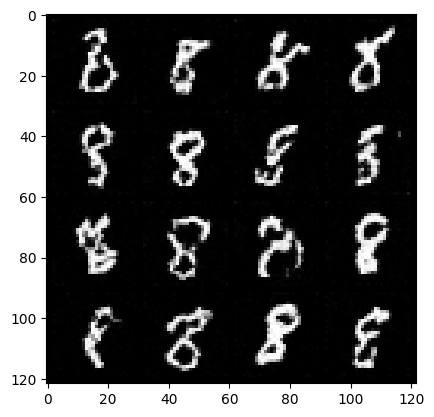

Validation: |          | 0/? [00:00<?, ?it/s]

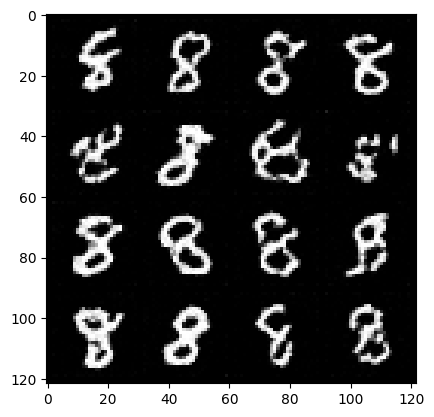

Validation: |          | 0/? [00:00<?, ?it/s]

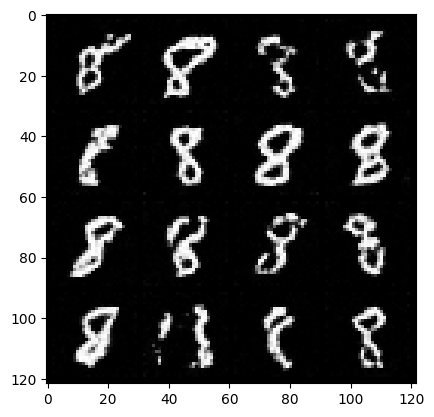

Validation: |          | 0/? [00:00<?, ?it/s]

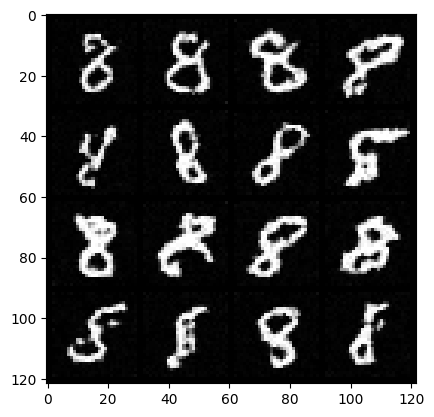

Validation: |          | 0/? [00:00<?, ?it/s]

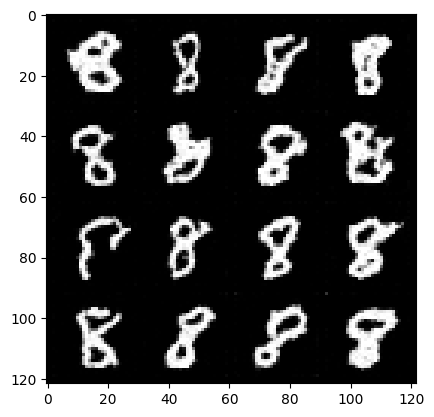

Validation: |          | 0/? [00:00<?, ?it/s]

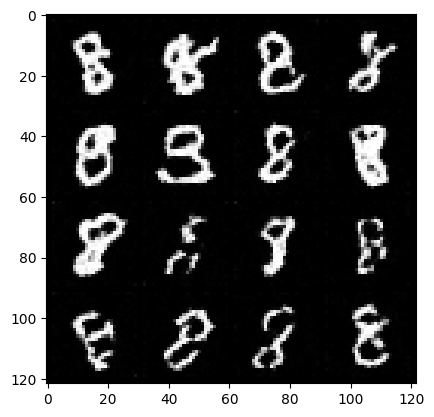

Validation: |          | 0/? [00:00<?, ?it/s]

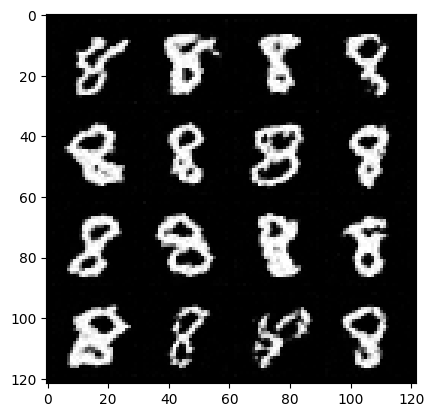

Validation: |          | 0/? [00:00<?, ?it/s]

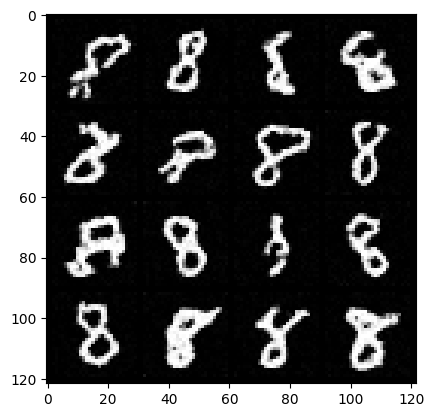

Validation: |          | 0/? [00:00<?, ?it/s]

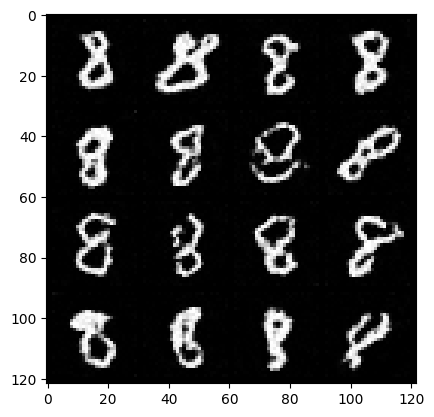

Validation: |          | 0/? [00:00<?, ?it/s]

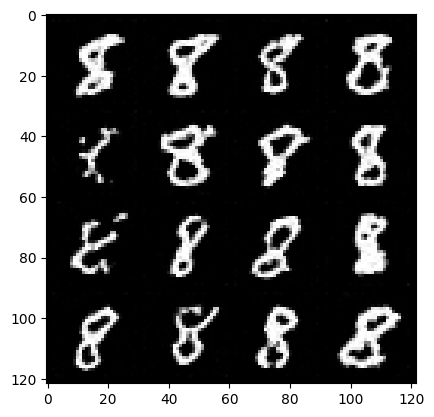

Validation: |          | 0/? [00:00<?, ?it/s]

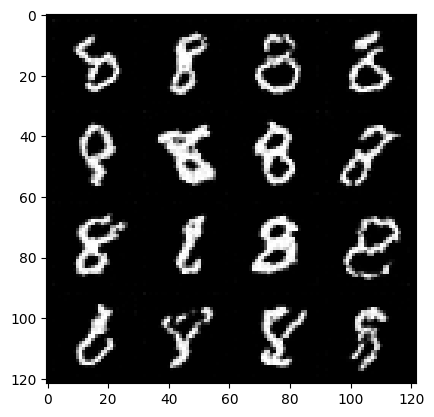

Validation: |          | 0/? [00:00<?, ?it/s]

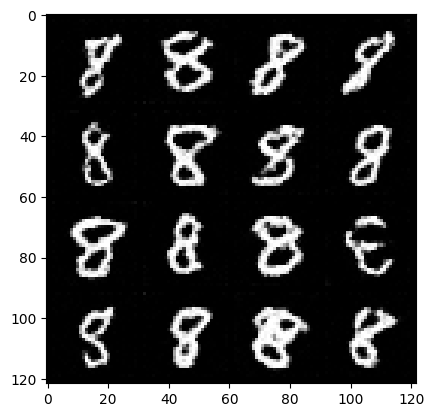

Validation: |          | 0/? [00:00<?, ?it/s]

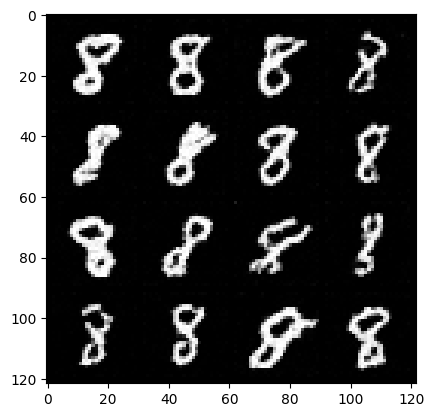

Validation: |          | 0/? [00:00<?, ?it/s]

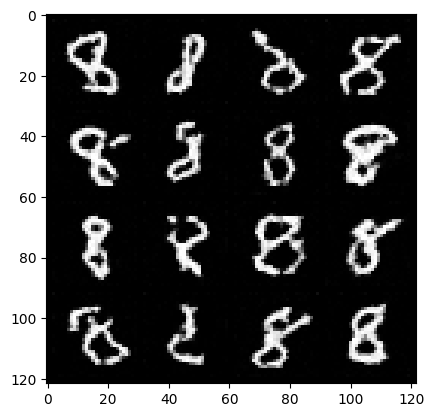

Validation: |          | 0/? [00:00<?, ?it/s]

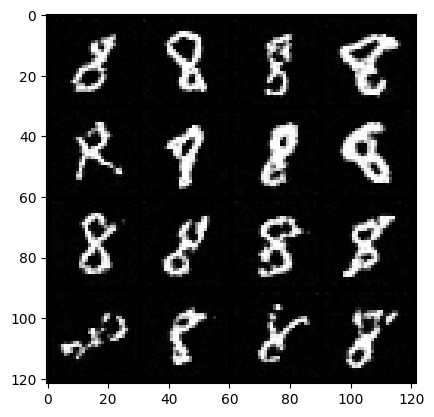

Validation: |          | 0/? [00:00<?, ?it/s]

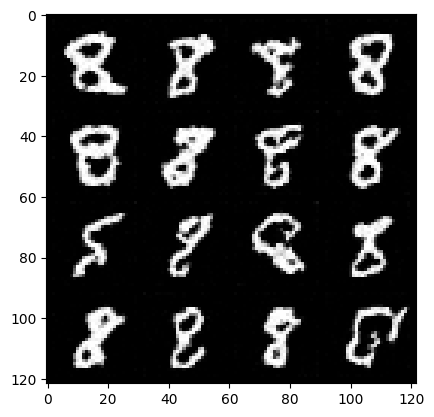

Validation: |          | 0/? [00:00<?, ?it/s]

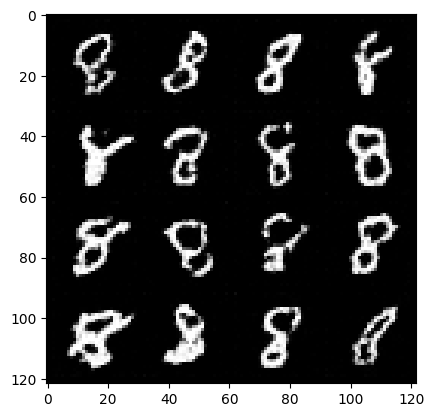

Validation: |          | 0/? [00:00<?, ?it/s]

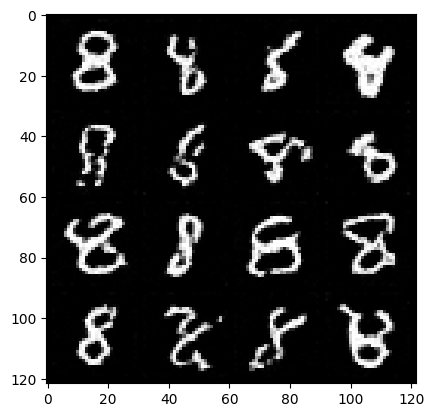

Validation: |          | 0/? [00:00<?, ?it/s]

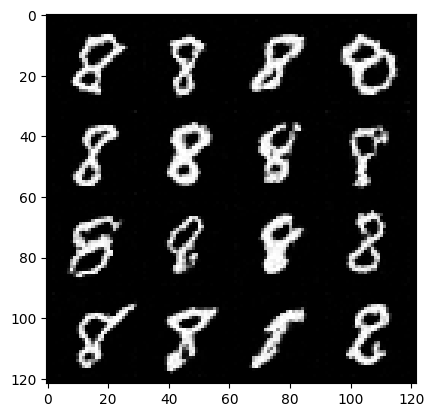

Validation: |          | 0/? [00:00<?, ?it/s]

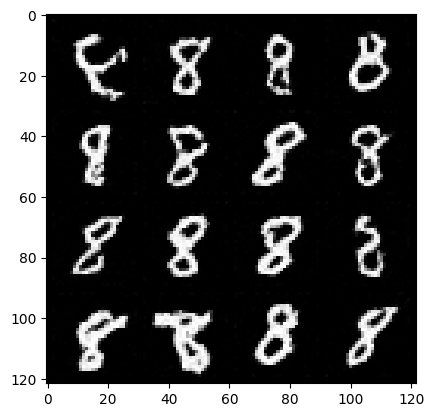

Validation: |          | 0/? [00:00<?, ?it/s]

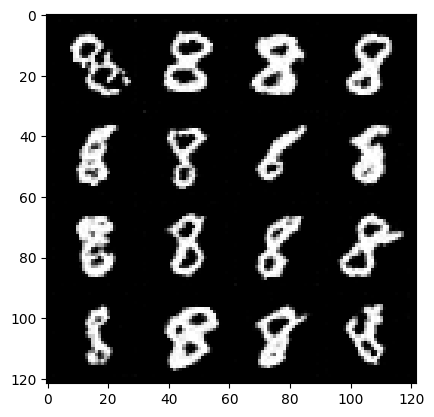

Validation: |          | 0/? [00:00<?, ?it/s]

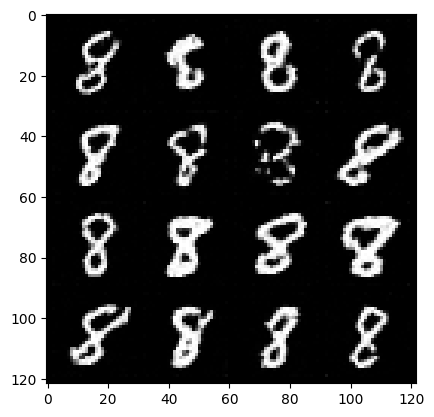

Validation: |          | 0/? [00:00<?, ?it/s]

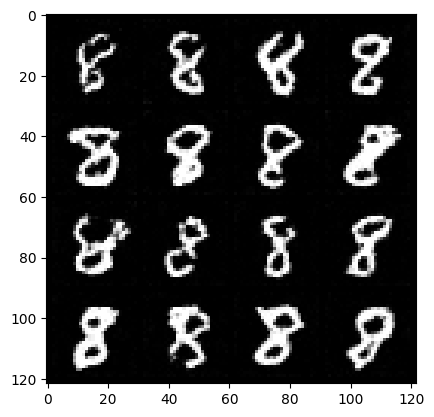

Validation: |          | 0/? [00:00<?, ?it/s]

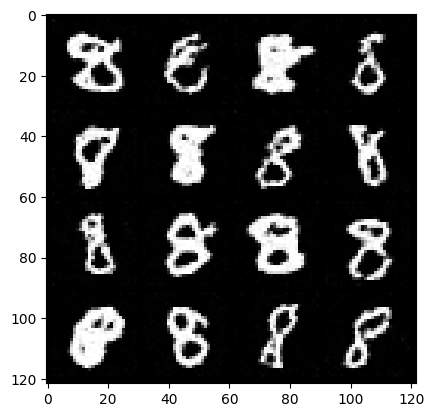

Validation: |          | 0/? [00:00<?, ?it/s]

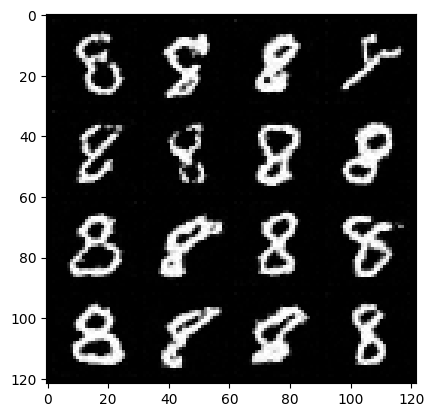

Validation: |          | 0/? [00:00<?, ?it/s]

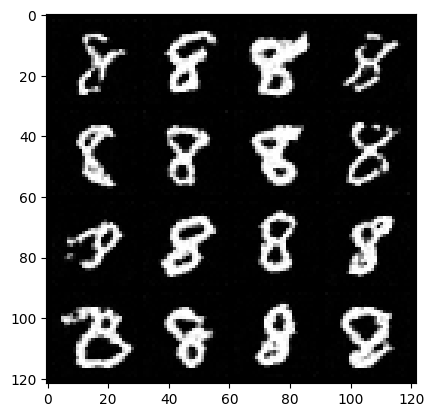

Validation: |          | 0/? [00:00<?, ?it/s]

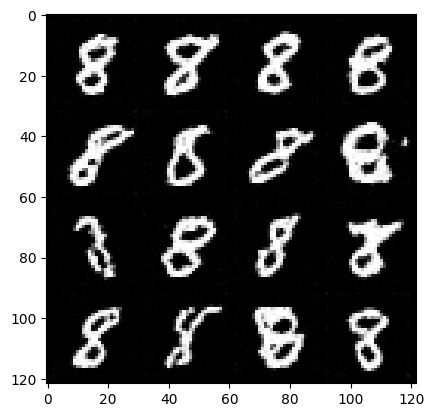

Validation: |          | 0/? [00:00<?, ?it/s]

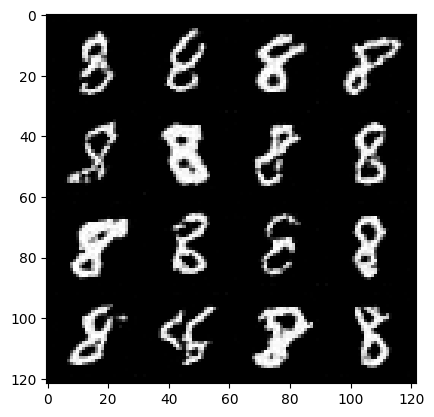

Validation: |          | 0/? [00:00<?, ?it/s]

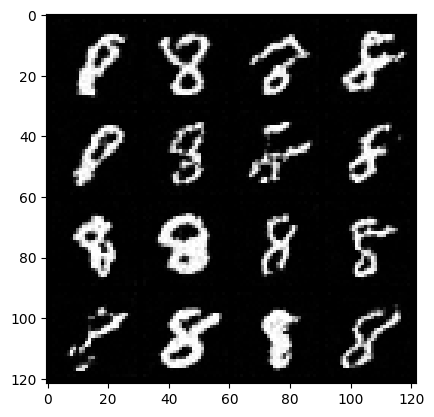

Validation: |          | 0/? [00:00<?, ?it/s]

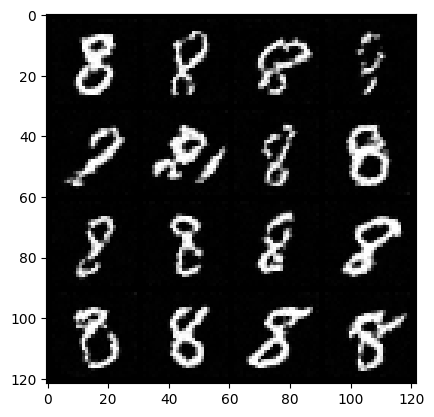

Validation: |          | 0/? [00:00<?, ?it/s]

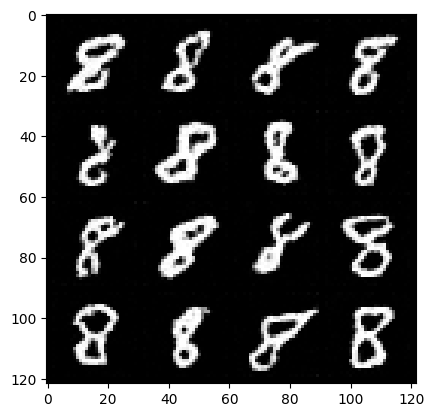

Validation: |          | 0/? [00:00<?, ?it/s]

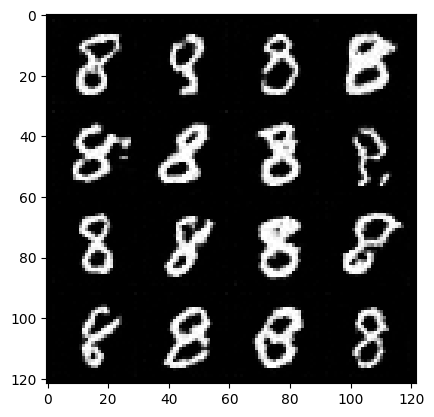

Validation: |          | 0/? [00:00<?, ?it/s]

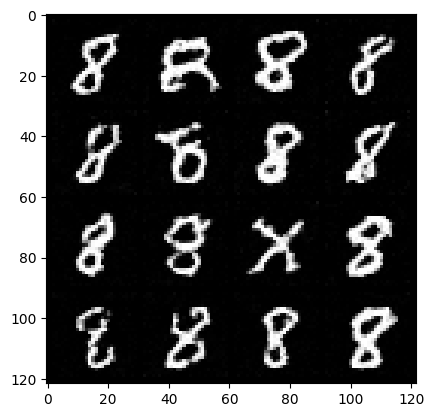

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
trainer.fit(model, train_dloader, test_dloader)

# Saving the model for later use

In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/PIMA/FlowMatching/model.ckpt")

# Loading the model

In [ ]:
model = ImageFlowMatcher.load_from_checkpoint("/content/drive/MyDrive/PIMA/FlowMatching/model.ckpt")

In [ ]:
sample_images = model.generate(batch_size=128, num_steps=1000)

/usr/local/lib/python3.11/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


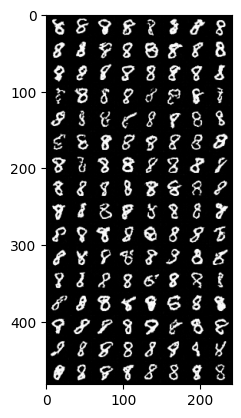

In [ ]:
grid = torchvision.utils.make_grid(sample_images, nrow=8, normalize=False, value_range=(0,1))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()
plt.close()

# Evaluation: Classifier and FID score
## Classifier

In [ ]:
# Converting the image from tensor to numpy
images_np = sample_images.detach().cpu().numpy()

# Reshaping the images from (N, 1, 28, 28) to (N, 784)
images_np = images_np.reshape(images_np.shape[0], 784)
images_np = images_np.astype('float32')
print("Input shape:", images_np.shape)

Input shape: (128, 784)


In [ ]:
# Loading the Classifier model to evaluate
from tensorflow.keras.models import load_model
classifier = load_model("/content/drive/MyDrive/PIMA/Classifier/classifier_model.h5")

In [ ]:
# Predicting
import numpy as np
predictions = classifier.predict(images_np)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted labels:", predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted labels: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 1 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 2 8 8 8 8 8 8 2 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 8 2 8 8 8 8 8 8]


In [ ]:
N = len(predicted_labels)
true_labels = np.full(N, 8)
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.53%


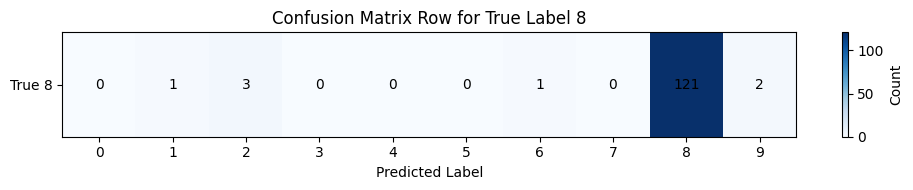

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Computing the full confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(10))

# Extracting the row for true label 8
cm_row_8 = cm[8:9, :]  # shape (1, 10)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(cm_row_8, cmap="Blues", aspect='auto')

for j in range(10):
    count = cm_row_8[0, j]
    ax.text(j, 0, str(count), ha="center", va="center", color="black")

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticks([0])
ax.set_yticklabels(["True 8"])
ax.set_xlabel("Predicted Label")
ax.set_title("Confusion Matrix Row for True Label 8")

plt.colorbar(im, ax=ax, orientation='vertical', label='Count')
plt.tight_layout()
plt.show()

## FID score

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

In [ ]:
import torch

from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T
# Initializing the FID metric
fid = FrechetInceptionDistance(feature=64)

In [ ]:
X.shape

torch.Size([5851, 1, 28, 28])

In [ ]:
# Adding real images to FID
for x in X:
    # x: (B, 1, 28, 28), float in [0, 1]
    x = x.unsqueeze(0)
    x = torch.nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    x = x.repeat(1, 3, 1, 1)  # (B, 3, 299, 299)
    x = (x * 255).clamp(0, 255).byte()

    fid.update(x, real=True)

In [ ]:
x_fake = sample_images.detach().cpu().clip(-1, 1)  # (N, 1, 28, 28)

# Converting to [0, 1] and to 3-channel 299x299 for FID
x_fake = (x_fake + 1) / 2
x_fake = torch.nn.functional.interpolate(x_fake, size=(299, 299))
x_fake = x_fake.repeat(1, 3, 1, 1)  # (N, 3, 299, 299)
# Scaling to [0, 255] and convert to uint8
x_fake = (x_fake * 255).clamp(0, 255).byte()

# Adding the generated images
fid.update(x_fake, real=False)

# Computing FID
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.2f}")

FID Score: 21.33
